In [2]:
from typing import List, Set, Tuple
import os

import cirq
import stim
import stimcirq

In [3]:
distances = [3, 5, 7]                       # Color code distance.
nshots = 100_000                        # Number of samples/shots
depths = range(10, 600, 50)

noise_rate = 1e-3
noise = cirq.depolarize
simulator = stimcirq.StimSampler()

In [4]:
import dataclasses


@dataclasses.dataclass
class Tile:
    qubits: list
    color: str


def make_color_code_tiles(*, base_data_width):
    if not (base_data_width % 2 == 1 and base_data_width >= 3):
        raise ValueError(f"{base_data_width=} wasn't an odd number at least as large as 3.")
    w = base_data_width * 2 - 1

    def is_in_bounds(q: complex) -> bool:

        if q.imag < 0:

            return False
        if q.imag * 2 > q.real * 3:

            return False
        if q.imag * 2 > (w - q.real) * 3:

            return False
        return True


    tiles = []
    hexagon_offsets = [-1, +1j, +1j + 1, +2, -1j + 1, -1j]
    for x in range(1, w, 2):
        for y in range((x // 2) % 2, w, 2):
            q = x + 1j * y

            tile = Tile(
                color=['red', 'green', 'blue'][y % 3],

            
                qubits=[
                    q + d
                    for d in hexagon_offsets
                    if is_in_bounds(q + d)
                ],
            )

            if len(tile.qubits) in [4, 6]:
                tiles.append(tile)

    return tiles

def get_stabilizer_generators(distance: int):
    tiles = make_color_code_tiles(base_data_width=distance)
    all_qubits = {q for tile in tiles for q in tile.qubits}

    # Only difference here is with the chromobius notebook that we rever
    sorted_qubits = reversed(sorted(all_qubits, key=lambda q: (q.imag, q.real)))
    q2i = {q: i for i, q in enumerate(sorted_qubits)}

    sorted_tiles = []
    for tile in tiles:
        sorted_tiles.append([q2i[q] for q in tile.qubits])

    stabilizers_x = []
    stabilizers_z = []
    for tile in sorted_tiles:
        stab_x = ""
        stab_z = ""
        for i in range(int((3*distance**2+1)/4)):
            if i in tile:
                stab_x+="X"
                stab_z+="Z"
            else:
                stab_x+="I"
                stab_z+="I"
        stabilizers_x.append(stab_x)
        stabilizers_z.append(stab_z)

    return stabilizers_x + stabilizers_z

def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    # Note: Look at https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md
    # For the different method of encoding

    return tableau.to_circuit(method='graph_state')

# Z Experiment

## Unmitigated

In [5]:
unmit_evs = []
for depth in depths:
    c = cirq.Circuit([cirq.X.on(cirq.LineQubit(0))]*depth).with_noise(noise(noise_rate))
    c.append(cirq.measure(cirq.LineQubit(0), key="m"))
    ev = simulator.run(c, repetitions=nshots).histogram(key="m")[0] / nshots
    print(ev)
    unmit_evs.append(ev)

0.99346
0.96204
0.93126
0.90523
0.87765
0.85314
0.8295
0.80663
0.78945
0.77143
0.75667
0.73685


## Mitigated

In [6]:
def expectation(counts, logical0, logical1) -> Tuple[float, float]:
    # From YLF
    p0 = 0.0
    p1 = 0.0
    for state in logical0:
        if state in counts:
            p0 += counts[state]
    for state in logical1:
        if state in counts:
            p1 += counts[state]
    obs_value = (p0-p1)/(p0+p1) if p0+p1 > 0 else None
    prop_cw = (p0+p1) / sum(counts.values())
    return obs_value, prop_cw

In [7]:
def get_encoding(distance) -> Tuple[Set[int], Set[int], List[cirq.LineQubit], cirq.Circuit]:
    generator_strs = get_stabilizer_generators(distance)
    n = len(generator_strs[0])
    qreg = cirq.LineQubit.range(n)

    encoding_circuit = stimcirq.stim_circuit_to_cirq_circuit(stabilizers_to_encoder([stim.PauliString(s) for s in generator_strs]))

    if(os.path.exists(f"cw-d={distance}.txt")):
        logical0 = set()
        with open(f"cw-d={distance}.txt") as fp:
            for line in fp.readlines():
                logical0.add(int(line))

    else:
        encoding0 = encoding_circuit + [cirq.measure(qreg, key="m")]
        logical0 = set(simulator.run(encoding0, repetitions=100*2**(n//2)).histogram(key='m').keys())
        with open(f"cw-d={distance}.txt", "w") as fp:
            for cw in logical0:
                fp.write(f"{cw}\n")

    logical1 = set(int("".join(["0" if ch=="1" else "1" for ch in ["0"]*(n-len(bin(cw)[2:])) + list(bin(cw)[2:])]), 2) for cw in logical0)

    return logical0, logical1, qreg, encoding_circuit

In [8]:
all_mit_evs = []
all_ps = []
for distance in distances:

    logical0, logical1, qreg, encoding_circuit = get_encoding(distance)
    n = len(qreg)

    print(f"{len(logical0)} code words for distance {distance}")

    mit_evs = []
    ps = []

    for depth in depths:
        noisy_circuit = encoding_circuit.copy()
        for _ in range(depth):
            noisy_circuit.append(cirq.X.on_each(qreg))
        noisy_circuit = noisy_circuit.with_noise(noise(noise_rate))
        noisy_circuit.append(cirq.measure(qreg, key="m"))

        counts = simulator.run(noisy_circuit, repetitions=100*2**(n//2)).histogram(key='m')
        ev, p = expectation(counts, logical0, logical1)
        print(ev, p)
        mit_evs.append(ev)
        ps.append(p)
    
    all_mit_evs.append(mit_evs)
    all_ps.append(ps)


8 code words for distance 3
1.0 0.895
0.9966499162479062 0.74625
0.9767441860465116 0.5375
0.9728997289972899 0.46125
0.9591836734693877 0.3675
0.9363957597173145 0.35375
0.8849557522123894 0.2825
0.8372093023255814 0.215
0.7218543046357616 0.18875
0.6527777777777778 0.18
0.6944444444444444 0.18
0.48484848484848486 0.165
512 code words for distance 5
0.9982205526172705 0.39513671875
0.9972803916236062 0.21544921875
0.9929554915145693 0.1219921875
0.9824163357912649 0.0688671875
0.9758812615955473 0.042109375
0.9438285291943829 0.02642578125
0.9095354523227384 0.0159765625
0.886986301369863 0.01140625
0.7433155080213903 0.0073046875
0.7809187279151943 0.00552734375
0.574468085106383 0.00458984375
0.5161290322580645 0.0036328125
262144 code words for distance 7
0.9998393142487594 0.03845897674560547
0.9994566529823714 0.0126373291015625
0.9977977642903075 0.004330482482910156
0.995205010274978 0.001559295654296875
0.9860833709168224 0.0005920791625976563
0.9681159420289855 0.000236892700

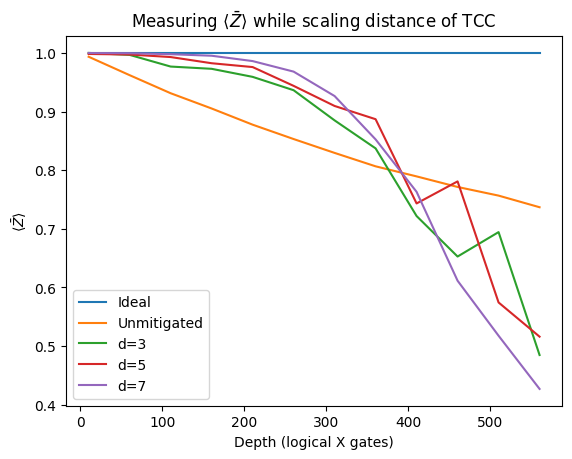

In [9]:
import matplotlib.pyplot as plt

plt.plot(depths, [1.0]*len(depths), label="Ideal")
plt.plot(depths, unmit_evs, label="Unmitigated")

for i, d in enumerate(distances):
    plt.plot(depths, all_mit_evs[i], label=f"d={d}")

plt.title("Measuring $\\langle \\bar{Z}\\rangle$ while scaling distance of TCC")
plt.ylabel("$\\langle \\bar{Z}\\rangle$")
plt.xlabel("Depth (logical X gates)")
plt.legend()

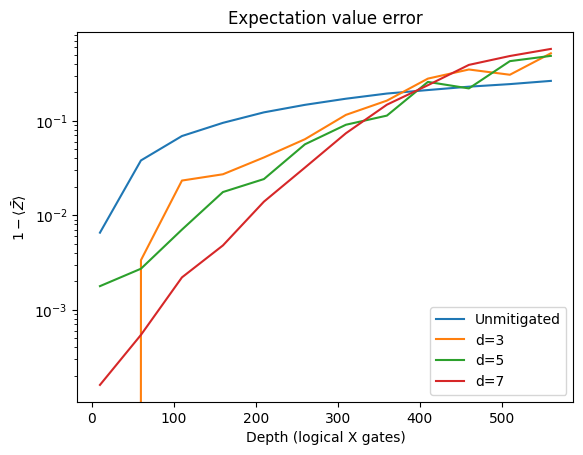

In [12]:
# plt.plot(depths, [1-ev for ev in unmit_evs], label="Unmitigated")
plt.semilogy(depths, [1-ev for ev in unmit_evs], label="Unmitigated")
for i, d in enumerate(distances):
    # plt.plot(depths, [1-ev for ev in all_mit_evs[i]], label=f"d={d}")
    plt.semilogy(depths, [1-ev for ev in all_mit_evs[i]], label=f"d={d}")

plt.title("Expectation value error")
plt.ylabel("$1-\\langle \\bar{Z} \\rangle$")
plt.xlabel("Depth (logical X gates)")
plt.legend()

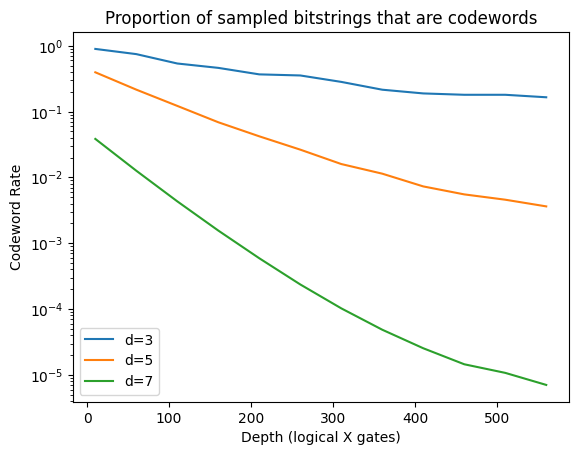

In [13]:
for i, d in enumerate(distances):
    plt.semilogy(depths, all_ps[i], label=f"d={d}")

plt.title("Proportion of sampled bitstrings that are codewords")
plt.ylabel("Codeword Rate")
plt.xlabel("Depth (logical X gates)")
plt.legend()